### Read xlsx data and import libraries

In [1]:
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import graphviz

datafile = pd.read_excel('atus/ehresp_2014.xlsx')

### Replace all nonvalid value codes with 0 and remove all rows where the BMI or GenHealth data is missing.

In [2]:
# works on datafile, result is dataset

dataset = datafile.applymap(lambda x: max(x,0))
empty_rows = list()
for i in range(dataset.shape[0]):
    if dataset.iloc[i]['erbmi'] == 0 or dataset.iloc[i]['eugenhth']==0:
        empty_rows.append(i)
dataset.drop(index=empty_rows, inplace=True)
dataset.dropna(axis=0,subset=['erbmi','eugenhth'],inplace=True)
dataset = dataset.reset_index(drop=True)

### Look at how respondants rated their General Health on a scale from one to five, with one being 'Excellent' and five being 'Poor'

#### We can see that 75% of responents rated their Health Good, Very Good, or Excellent.

In [16]:
dataset['eugenhth'].describe()

count    10607.000000
mean         2.507684
std          1.064182
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: eugenhth, dtype: float64

### Create column 'bmi' by categorizing data in 'erbmi'

In [3]:
def bmi_intlabel(x):
    if x <= 0:
        return 0
    elif x < 18.5:
        return 1
    elif x < 25:
        return 2
    elif x < 30:
        return 3
    return 4

bmi_labels=["Unreported","Underweight","Healthy","Overweight","Obese"]
hthlabels = ["Unreported", "Excellent", "Very Good", "Good", "Fair","Poor"]

bmi_data = list()
for i in range(dataset.shape[0]):
    bmi_data.append(int(bmi_intlabel(dataset.iloc[i]['erbmi'])))

df_temp = pd.DataFrame({"bmi": pd.Series(bmi_data)})
dataset = pd.concat([dataset,df_temp],axis=1,sort=False)

### Create Column 'income' from column 'erincome'
(erincome combines data from two different questions, but it's values of 2,3, and 4 are hard to differentiate, so combine into one value of 2)

In [4]:
income_data = list()
for i in range(dataset.shape[0]):
    income = int(dataset.iloc[i]['erincome'])
    if income == 3 or income == 4:
        income = 2
    income_data.append(income)
df_temp = pd.DataFrame({"income": income_data})
dataset = pd.concat([dataset,df_temp],axis=1,sort=False)

### Define a function to One Hot Encode selected categorical columns from a dataframe

In [5]:
def onehot_categorical_columns(file, columns):
    # Adapted from prepare_categorical_columns in Eric Heilander's prepareData notebook   
    # Extract columns from file; convert to array
    dataset = file[columns]
    
    # Apply LabelEncoder to multiple columns: https://stackoverflow.com/a/31939145
    dataset = pd.DataFrame(dataset).apply(LabelEncoder().fit_transform)

    # OHE for multiple columns using pd.get_dummies: https://stackoverflow.com/a/44601764
    # Another get_dummies example: http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
    # OHE vs. get_dummies: https://medium.com/@guaisang/handling-categorical-features-get-dummies-onehotencoder-and-multicollinearity-f9d473a40417
    dataset_df = pd.DataFrame(dataset, columns=columns)
    # Keep only the columns we want, and drop the extraneous dummy column
    dataset_dummies = pd.get_dummies(dataset_df,
                                     columns=columns,
                                     drop_first=True)
    dataset = dataset_dummies
    return dataset

### Onehot categorical columns  and remerge with numerical columns.

In [6]:
numerical_columns = ['ertpreat', # total amount of time spent in primary eating and drinking \
                     'ertseat',  # time spent in secondary eating \
                     'euexfreq',  # reported number of times exercised in last week \
                     'eufastfdfrq']  # reported number of times buying fast food or prepared food 
                     
categorical_columns = [#'eeincome1',  # is income greater than, less than, or equal to 185% of poverty threshold \
                       'erhhch',  # Change in Household composition \
                       #'erincome',  # replaced with income column \
                       'erspemch',  # change in spouse's employment
                       #'ethgt',  # topcode flag, is metadata
                       #'etwgt',  # topcode flag, is metadata
                       'eudietsoda',  # Was the softdrink diet, regular, or both
                       'eudrink',  # Did you drink non-water beveridges yesterday
                       'eueat',  # Did you eat or drink while doing something else ?
                       'euexercise', # Did you exercise in the last week ?
                       'eufastfd',  # Did you eat any fast food last week 
                       'euffyday',  # Did you eat fast food yesterday ?
                       'eufdsit',  # Did you get enough to eat yesterday ?
                       'eusnap',  # Did anyone in your household get food stamps ?
                       #'eugenhth',  # Is a target
                       'eugroshp',  # Are you the primary grocery shopper ?
                       #'euinclvl',  # Which year's primary threshold was used
                       #'euincome2',  # incomed compared to 130% of poverty
                       'eumeat',  # Did you eat meat last week ?
                       'eumilk',  # Did you drink or serve raw milk ?
                       'euprpmel',  # Are you the main cook in your household ?
                       'eusoda',  # Did you drink soft drinks ?
                       'eustores',  # At what kind of store do you buy groceries ?
                       'eustreason',  # Why ?
                       'eutherm',  # Do you use a meat thermometer ?
                       'euwic',  # Did you get WIC benefits ?
                       'bmi', # categorized bmi
                       'income']

one_df = onehot_categorical_columns(dataset,categorical_columns)
numerical_df = dataset.loc[:,numerical_columns]
merged_df = pd.concat([numerical_df, one_df],axis=1,sort=False)

In [7]:
merged_df[:4]

,ertpreat,ertseat,euexfreq,eufastfdfrq,erhhch_1,erhhch_2,erspemch_1,erspemch_2,erspemch_3,erspemch_4,...,eutherm_1,eutherm_2,euwic_1,euwic_2,bmi_1,bmi_2,bmi_3,income_1,income_2,income_3
0,30,2,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0
1,45,14,0,1,0,1,0,0,0,0,...,0,1,0,1,1,0,0,1,0,0
2,60,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
3,65,0,5,0,0,1,0,0,0,0,...,0,1,1,0,0,0,1,0,0,1


## Train a Decision Tree Classifier using 'genhth' as the target

In [8]:
from sklearn.model_selection import train_test_split
hth_Xtrain, hth_Xtest, hth_ytrain, hth_ytest = train_test_split(merged_df, dataset['eugenhth'], test_size = 0.1)
hth_classifier = tree.DecisionTreeClassifier(max_depth = 5)
hth_classifier.fit(hth_Xtrain, hth_ytrain)
print()

## Display a decision tree showing the major predictors of general health 

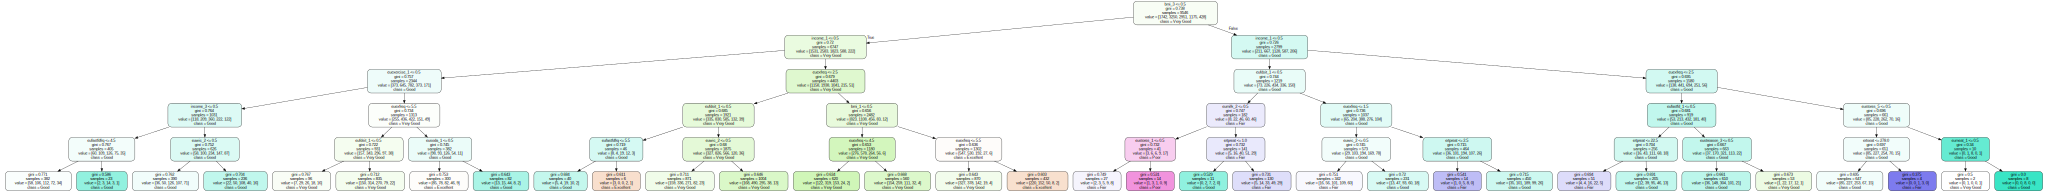

In [10]:
dot_data = tree.export_graphviz(hth_classifier,feature_names=merged_df.columns,class_names=hthlabels[1:],filled=True, rounded=True)
graph = graphviz.Source(dot_data)
#graph.render("BMI")
graph

### Train a classifier to predict BMI

In [11]:
bmi_columns = [x for x in merged_df.columns if 'bmi' not in x]
bmi_X = merged_df.loc[:,bmi_columns]
bmi_classifier = tree.DecisionTreeClassifier(max_depth=3)
bmi_classifier.fit(bmi_X, dataset['bmi'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Display a decision tree showing the major predictors of BMI classes

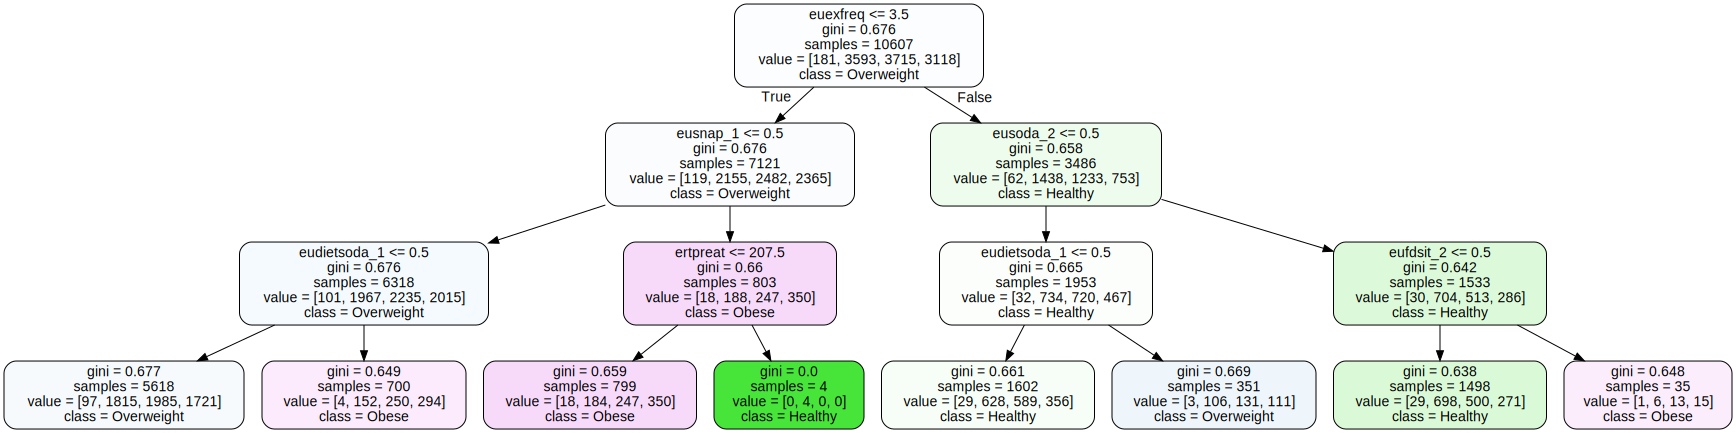

In [12]:
bmi_dot_data = tree.export_graphviz(bmi_classifier,feature_names=bmi_X.columns,class_names=bmi_labels[1:],filled=True, rounded=True)
bmi_graph = graphviz.Source(bmi_dot_data)
#graph.render("BMI")
bmi_graph